In [30]:
""" Helper imports"""
import re
import html.parser
import pandas as pd
import unicodedata
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
import string
from datetime import date, timedelta
from collections import Counter
from operator import itemgetter
import joblib
from sklearn.metrics.pairwise import cosine_similarity
import scipy

""" Plotting imports"""
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

""" Google imports"""
from google.cloud import bigquery

# remove this later
pd.set_option('max_colwidth', 110)
import warnings
warnings.filterwarnings('ignore')

### ---Helper functions---

In [2]:
from google.cloud import storage

storage_client = storage.Client()
bucket_name = 'keyword-extraction-new'
bucket_folder = 'nlp_util_variables/' 

contraction_source = 'contraction_dictionary.pkl'
stopw_source = 'forbes_stop_words.pkl'

data_path = '/home/jupyter/bi-topic-modeling/data/' 
contraction_destination = data_path + 'contraction_dictionary.pkl'
stopw_destination = data_path + 'forbes_stop_words.pkl'

bucket = storage_client.bucket(bucket_name)

blob1 = bucket.get_blob(bucket_folder + contraction_source)
blob1.download_to_filename(contraction_destination)
print("Blob {} downloaded to {}.".format(bucket_folder + contraction_source, contraction_destination))
print()
blob2 = bucket.get_blob(bucket_folder + stopw_source)
blob2.download_to_filename(stopw_destination)
print("Blob {} downloaded to {}".format(bucket_folder + stopw_source, stopw_destination))

Blob nlp_util_variables/contraction_dictionary.pkl downloaded to /home/jupyter/bi-topic-modeling/data/contraction_dictionary.pkl.

Blob nlp_util_variables/forbes_stop_words.pkl downloaded to /home/jupyter/bi-topic-modeling/data/forbes_stop_words.pkl


In [2]:
# Contraction dictionary
data_path = '/home/jupyter/bi-topic-modeling/data/' 

contraction_destination = data_path + 'contraction_dictionary.pkl'
c_dict = pd.read_pickle(contraction_destination)

# Compiling the contraction dict
c_re = re.compile('(%s)' % '|'.join(c_dict.keys()))

def listToString(s):  
    str1 = " " 
    return (str1.join(s)) 

# Function to expand contractions
def expandContractions(text, c_re=c_re):
    def replace(match):
        return c_dict[match.group(0)]
    return c_re.sub(replace, text)

# Function to remove unicode
def normalize_unicode(input_str):
    
    # replaces accents by converting to byte literal and then decoding to utf-8.
    nfkd_form = unicodedata.normalize('NFKD', input_str) 
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    return only_ascii.decode("utf-8")  

# Function to remove the html
class HTMLTextExtractor(html.parser.HTMLParser):
    def __init__(self):
        super(HTMLTextExtractor, self).__init__()
        self.result = []
    def handle_data(self, d):
        self.result.append(d)
    def get_text(self):
        return ''.join(self.result)

def html_to_text(html):
    s = HTMLTextExtractor()
    s.feed(html)
    return s.get_text()

def remove_html(text):
    text = str(text)
    string = re.sub('<[^<]+?>', ' ', text)
    string = html_to_text(string)
    string = re.sub('’', "'", string) 
    string = re.sub(r'[^\x00-\x7F]+', ' ', string) # [^\x00-\x7F]+ searches for all non-ASCII values
    string = re.sub(r'\[.*?\]', ' ', string) # escape special characters mentioned inside []
    string = string.replace('\r', '  ')
    string = string.replace('\n', '  ')
    string = re.sub(' +', ' ', string)
    return string

# Function to remove newline character
def remove_newline(string):
    string = string.replace('\r', '') # remove carriage return
    return string.replace('\n', '') # remove newline

In [3]:
# Note: not included 'Thursday' and 'Friday' because of thanksgiving and black friday related mentions
STOP_WORDS = pd.read_pickle(data_path + 'forbes_stop_words.pkl')
"q1" in STOP_WORDS

True

### ---Exploration---

In [4]:
#Query BQ into DF
client = bigquery.Client()

In [18]:
# pulling in tiers from mnet_iab, just in case
sql = """
   WITH content_iab AS (
   SELECT * FROM (
        SELECT 
            naturalId AS iab_natid, 
            RANK() OVER (PARTITION BY naturalid ORDER BY timestamp DESC) AS mostrecent,
            categoryName,
            tier1,
            tier2,
            tier3
        FROM `api-project-901373404215.Content.mnet_iab_categories` where tier1 IS NOT NULL
        ) 
    WHERE mostrecent = 1
    ),

    content AS (
      SELECT 
        natid AS content_natid,
        EXTRACT(DATE FROM date_et) AS pub_date,
        title, 
        body
      FROM (
        SELECT DISTINCT
          LOWER(NaturalId) AS natid,
          DATETIME(date, "America/New_York") as date_et,
          RANK() OVER (PARTITION BY naturalid ORDER BY timestamp DESC) AS mostrecent,
          title, 
          body
        FROM
          `api-project-901373404215.Content.content`
        WHERE
          Visible is true
          AND type in (
          'blog',
          'blogslide',
          'magazine')
          )
      WHERE mostrecent = 1
    )

    # Join the content iab table with the main content table to get the title with the iab category
      SELECT
        * 
        EXCEPT(iab_natid)
      FROM
        content_iab
      INNER JOIN
        content
      ON
        LOWER(iab_natid) = LOWER(content_natid)
        ORDER BY pub_date DESC
        LIMIT 50000
"""

# Send the query to the api and return a df
df = client.query(sql).to_dataframe()
print("Shape: ", df.shape)

Shape:  (50000, 9)


In [19]:
df.head(1)

,mostrecent,categoryName,tier1,tier2,tier3,content_natid,pub_date,title,body
0,1,Computer Software and Applications,Technology & Computing,Computing,Computer Software and Applications,blogandpostid/blog/post/6803-6023eb1ad61df20006dff468,2021-12-31,76% Of Smartphone Owners Use Mobile Apps To Manage Their Finances,"[id=23]<h2 class=""subhead-embed color-accent bg-base font-accent font-size text-align"">OBSERVATIONS FROM T..."
1,1,Real Estate Buying and Selling,Real Estate,Real Estate Buying and Selling,None,blogandpostid/blog/post/4254-608055bc7bb57e000629e54a,2021-04-22,How SaaS Real Estate Enterprises Can Use Content Marketing And Data To Reshape Their Businesses,"<p><em>Kara Taylor is Vice President of Marketing at&nbsp;</em><a href=""https://www.attomdata.com/"" target..."
2,1,Non-Profit Organizations,Business and Finance,Industries,Non-Profit Organizations,blogandpostid/blog/post/1979-6080289443bb480006f0c1bc,2021-04-22,A Review Of The Effective Altruist Charitable Giving Strategy,"[id=2]<p>Recently, I read William MacAskill's 2016 book ""Doing Good Better"" in which he talks about how th..."
3,1,Automotive,Automotive,None,None,blogandpostid/blog/post/4463-607f0c7d6e5ed40006769a4b,2021-04-22,"Meet Kate Courtney, Mountain Bike World Champion And 2021 U.S. Olympic Hopeful",[id=0]<p>The sport of mountain biking was invented in the United States. Americans dominated in the early ...
4,1,Business,Business and Finance,Business,None,blogandpostid/blog/post/3949-608080967ffbc20006ec2684,2021-04-22,Take A Seat At The Table And Translate Cyber Risks Into Business Risks,"<p><em>Reuven Aronashvili is the founder and CEO of&nbsp;</em><a href=""https://cyesec.com/"" target=""_blank..."


In [21]:
# Changing datatypes
df['content_natid']=df['content_natid'].astype(str)
df['title']=df['title'].astype(str)
df['body']=df['body'].astype(str)
df=df.sort_values(by='pub_date', ascending=False).reset_index(drop=True)

# Combine title and body
df['clean_body'] = df['title'] + ". " + df['body']

# Remove html, normalize unicode
df['clean_body'] = df['body'].astype(str).str.lower()
df['clean_body'] = df['clean_body'].apply(remove_newline).astype(str)
df['clean_body'] = df['clean_body'].apply(expandContractions, c_re=c_re)
df['clean_body'] = df['clean_body'].apply(normalize_unicode)
df['clean_body'] = df['clean_body'].apply(remove_html).str.strip()
df['clean_body'] = df['clean_body'].apply(lambda x: re.sub(r"<[^>]*>", " ", x)) 
df['clean_body'] =  df['clean_body'].replace('\s+', ' ', regex=True) # remove more than 1 space in between words 

In [23]:
df.drop_duplicates("content_natid", inplace=True)

### --- Article length EDA to weed out garbage --- 

In [24]:
df["article_length"] = df.clean_body.str.split().apply(len)
df["article_length"].describe()

count    49446.000000
mean       869.062351
std        516.793551
min          0.000000
25%        551.000000
50%        784.000000
75%       1026.000000
max      16955.000000
Name: article_length, dtype: float64

**Observation:**
* Articles less than 100 words are:
    * Those accompanying videos, photos or tweets pasted in them
    * Event info or intros
    * Short aritcles with sports-updates
    
**VERDICT:** Will be excluding any articles less than 100 words

In [28]:
df[df["article_length"]<100].tail(5)

,mostrecent,categoryName,tier1,tier2,tier3,content_natid,pub_date,title,body,clean_body,article_length
44765,1,Financial Reform,Business and Finance,Economy,Financial Reform,blogandpostid/blog/post/907-5fa47620b2bb980006d8d60d,2020-11-06,Why A Stimulus Bill Won’t Stimulate The Economy,[id=0]<p><strong>Wall Street is giddy</strong> over the possibility of a new stimulus package. But this ep...,wall street is giddy over the possibility of a new stimulus package. but this episode of whats ahead demon...,89
46323,1,Personal Taxes,Personal Finance,Personal Taxes,None,blogandpostid/blog/post/907-5f9a074bfcf35700063e8d13,2020-10-30,How Biden’s Tax Plan Will Hit You,"[id=0]<p><strong>This segment</strong> of <a href=""https://youtu.be/JKQgh62cVMQ"" target=""_blank"" class=""co...",this segment of whats ahead shows how joe bidens proposals for mammoth tax increases will adversely impact...,95
47832,1,College Football,Sports,College Sports,College Football,blogandpostid/blog/post/989-5f9322b2a37bd000062c5b79,2020-10-23,An Expert’s Insight On College Football’s TV Revenue Outlook,"[id=1]<p>How much money can college football’s <a href=""https://www.espn.com/college-football/story/_/id/2...","how much money can college footballs power five conferences acc, big ten, big 12, pac-12, secexpect to tak...",70
47862,1,Sports TV,Television,Sports TV,None,blogandpostid/blog/post/989-5f93281d16cd7e00060902cd,2020-10-23,What MLB’s Big Pay Days With Turner Sports And Fox Could Mean For Its ESPN Media Rights,[id=1]<p>Major League Baseball has cashed in by extending its media rights deals with Fox Sports and Turne...,major league baseball has cashed in by extending its media rights deals with fox sports and turner sportst...,91
48472,1,Baseball,Sports,Baseball,None,blogandpostid/blog/post/907-5f8dec4965411d0007c1f37f,2020-10-20,Is Major League Baseball Dying? What You Need To Know,"[id=0]<p>This episode of <a href=""https://youtu.be/r2vgwaO65GI"" target=""_blank"" class=""color-link"" title=""...",this episode of whats ahead examines why the hoopla surrounding the world series cant disguise a troubling...,94


In [18]:
df.to_csv(data_path + 'raw/articles.csv', index=False)

### --- General EDA --- 

* Input data = saved locally
* word cloud, n-grams, tier value_counts = to get themes 
* sentence lengths = to decide embeddings should be extracted at sentence level or article

In [4]:
df = pd.read_csv(data_path + 'raw/articles.csv')

In [5]:
df.tail(2)

,categoryName,tier1,tier2,content_natid,pub_date,title,body,clean_body
990,Retirement Planning,Personal Finance,Retirement Planning,blogandpostid/blog/post/1058-60256ddc3c0f2000064d24a3,2021-02-11,Ask Larry: Is A Break Even Analysis A Good Way To Decide When To Take My Social Security Benefits?,[id=0]<p>Today's column addresses questions about whether to decide when to file according to a break even...,ask larry: is a break even analysis a good way to decide when to take my social security benefits?. today'...
991,Law,News and Politics,Law,blogandpostid/blog/post/50531-6024ddf688d2130006c2cfa0,2021-02-11,"Biden Brings Up China’s Human Rights Abuses, ‘Unfair’ Economic Practices In First Call With Xi Jinping","<h2 class=""topline-heading"">Topline</h2><p>President Joe Biden confronted Chinese President Xi Jinping abo...","biden brings up chinas human rights abuses, unfair economic practices in first call with xi jinping. topli..."


**Data description**
* Random 1000 articles during the time period: 11-Feb-2021 to 17-Feb-2021

In [ ]:
sorted(df.pub_date.unique())

In [6]:
print(len(df.tier1.unique()))
df.tier1.value_counts()

29


Business and Finance        245
Personal Finance            120
Sports                       89
Technology & Computing       73
Medical Health               71
News and Politics            64
Video Gaming                 34
Automotive                   30
Travel                       23
Food & Drink                 23
Events and Attractions       22
Real Estate                  22
Style & Fashion              22
Careers                      21
Education                    19
Shopping                     18
Music and Audio              18
Movies                       17
Science                      17
Television                   13
Home & Garden                 7
Family and Relationships      6
Healthy Living                5
Hobbies & Interests           4
Pop Culture                   3
Fine Art                      2
Books and Literature          2
Religion & Spirituality       1
Pets                          1
Name: tier1, dtype: int64

In [7]:
business_finance = df[df.tier1 == "Business and Finance"]

In [8]:
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = nltk.word_tokenize(text)
    text = [x.lower() for x in text]
    text = [w for w in text if w not in STOP_WORDS]   
    text = [lemmatizer.lemmatize(x) for x in text]
    text = [w for w in text if w not in list(set(string.punctuation))]
    text = [re.sub('[0-9]+', '', x) for x in text]
    text = [x for x in text if len(x) > 1]
    
    return text

In [9]:
df['processed'] = df['clean_body'].apply(clean_text) 

In [10]:
from nltk import word_tokenize, pos_tag

def nouns(text):
    
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return all_nouns #' '.join(all_nouns)

df['processed_noun'] = df.clean_body.apply(nouns) 

**Observation:**
* Below words look pretty unhelpful. Looks like applying "only noun" filter on tokens would be helpful in
    * in reducing the feature space
    * hopefully, in getting coherent topics

In [11]:
print("Words excluded after applying noun only filter:")
print()
print(sorted([i for i in df.processed[0] if i not in df.processed_noun[0]]))

Words excluded after applying noun only filter:

['account', 'account', 'acorn', 'across', 'adult', 'advisor', 'among', 'among', 'among', 'area', 'asked', 'automatically', 'benefitting', 'better', 'big', 'big', 'big', 'billion', 'boomer', 'bought', 'brokerage/robo-advisor', 'cannabilizing', 'cardholder', 'caused', 'cheat', 'coming', 'comparing', 'complimentary', 'consumer', 'consumer', 'consumer', 'consumer', 'consumer', 'consumer', 'consumer', 'consumer', 'consumer', 'consumer', 'consumer', 'current', 'declined', 'declined', 'difference', 'difference', 'digital', 'displace', 'displaced', 'doesnt', 'dollar', 'dont', 'dont', 'dropped', 'encompass', 'fielded', 'figuring', 'finance', 'finance', 'financial', 'financial', 'financial', 'financial', 'financial', 'fintech-related', 'fintechs', 'fintechsand', 'followed', 'found', 'gaining', 'generational', 'generational', 'held', 'help', 'help', 'higher', 'higher', 'hold', 'holder', 'however', 'however', 'however', 'inadvertent', 'including', '

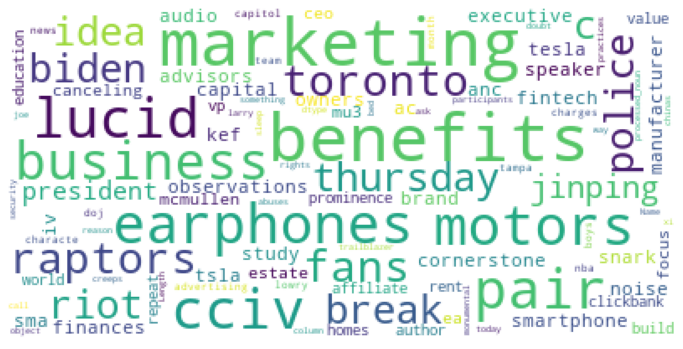

In [12]:
from wordcloud import WordCloud, STOPWORDS

mpl.rcParams['figure.figsize']=(12.0,12.0)  
mpl.rcParams['font.size']=12            
mpl.rcParams['savefig.dpi']=100             
mpl.rcParams['figure.subplot.bottom']=.1 
stopwords = set(STOP_WORDS)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=500,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(df['processed_noun']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();
# what the articles are about:

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(corpus, n=None):
    
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    return words_freq[:n]

common_words = get_top_n_words(df['clean_body'], 45)
df2 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])
df2.plot(x="unigram", y="count", kind="bar", figsize=(20,7), rot=45)

In [6]:
def get_top_n_bigram(corpus, n=None):
    
    vec = CountVectorizer(ngram_range=(2, 2), 
                          stop_words='english').fit(corpus)
    
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, 
                       key = lambda x: x[1], 
                       reverse=True)
    
    return words_freq[:n]

common_bi_words = get_top_n_bigram(df['clean_body'], 30)

df3 = pd.DataFrame(common_bi_words, columns = ['bigram' , 'count'])
df3.plot(x="bigram", y="count", kind="bar", figsize=(20,7), rot=45)

In [7]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_trigram(df['clean_body'], 25)
df4 = pd.DataFrame(common_words, columns = ['trigram' , 'count'])
df4.plot(x="trigram", y="count", kind="bar", figsize=(20,7), rot=45)

<AxesSubplot:>

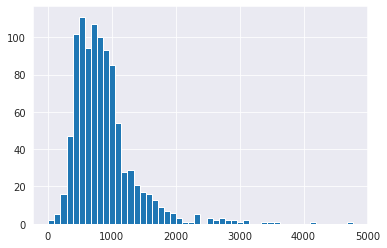

In [15]:
df["article_length"] = df.clean_body.str.split().apply(len)
df["max_sent_len"] = df.clean_body.apply(lambda elem: max([len(x.split()) for x in sent_tokenize(elem)]))
df["article_length"].hist(bins=50)

count     992.000000
mean       58.490927
std        40.363159
min         5.000000
25%        44.000000
50%        51.000000
75%        63.000000
max      1053.000000
Name: max_sent_len, dtype: float64



<AxesSubplot:>

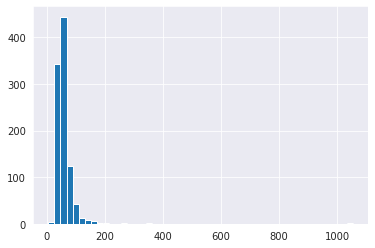

In [16]:
print(df["max_sent_len"].describe())
print()
df["max_sent_len"].hist(bins=50)

### --- EDA for articles on Apr 25 with pvs>100---
* Input = train_apr25_over100pvs_processed.csv

In [8]:
train_apr25 = pd.read_csv(data_path + "processed/train_apr25_over100pvs_processed.csv")
pred_apr26 = pd.read_csv(data_path + "processed/pred_apr26_over100pvs_processed.csv")
pred_apr27 = pd.read_csv(data_path + "processed/pred_apr27_over100pvs_processed.csv")

<AxesSubplot:xlabel='bigram'>

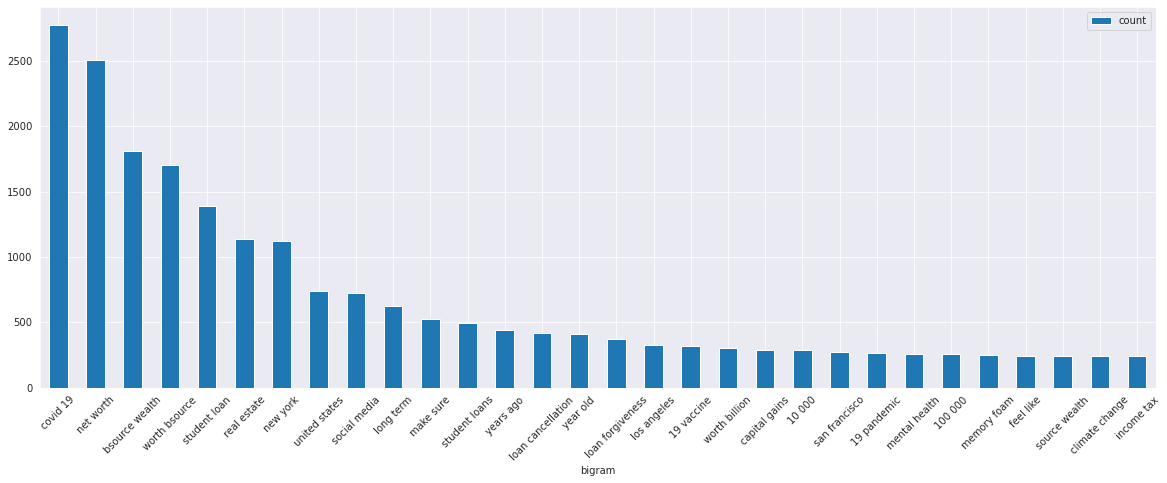

In [9]:
common_bi_words = get_top_n_bigram(train_apr25['clean_body'], 30)
df3 = pd.DataFrame(common_bi_words, columns = ['bigram' , 'count'])
df3.plot(x="bigram", y="count", kind="bar", figsize=(20,7), rot=45)

<AxesSubplot:xlabel='trigram'>

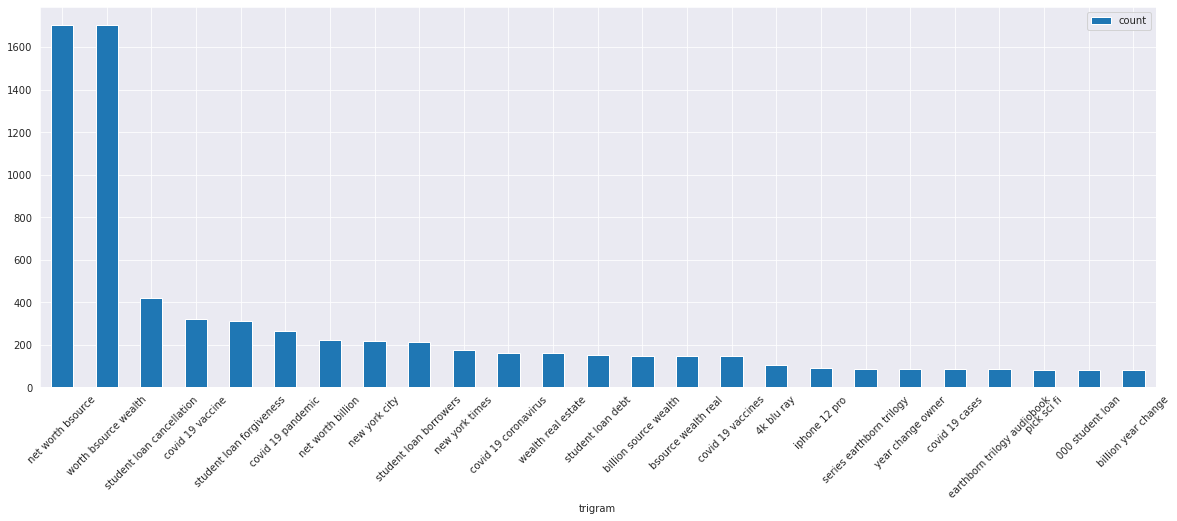

In [10]:
common_words = get_top_n_trigram(train_apr25['clean_body'], 25)
df4 = pd.DataFrame(common_words, columns = ['trigram' , 'count'])
df4.plot(x="trigram", y="count", kind="bar", figsize=(20,7), rot=45)

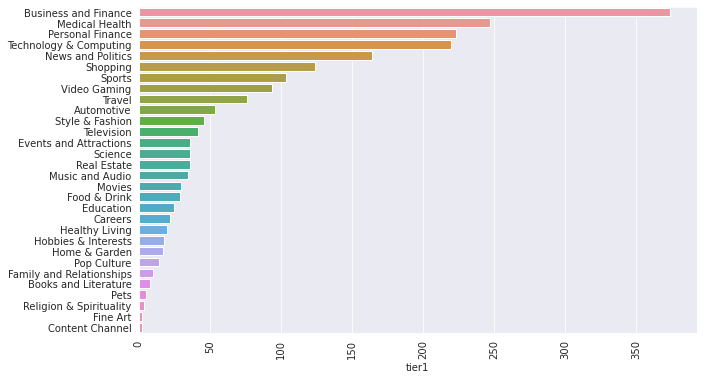

In [11]:
plt.figure(figsize=(10,6))
sns.barplot(x=train_apr25.tier1.value_counts(), y=train_apr25.tier1.value_counts().index)
plt.xticks(rotation=90)
plt.show()

### --- EDA for sanity check on embeddings ---

In [18]:
# Articles read on May 05 with over 100 pvs

df = pd.read_csv(data_path + 'processed/may05_over100pvs_processed.csv')

print("Shape:", df.shape)
print("Unique tiers:", len(df.tier1.unique()))

Shape: (4174, 8)
Unique tiers: 31


In [19]:
# Per verdict from EDA, exclude articles less than 100 words

df["article_length"] = df.clean_body.str.split().apply(len)
df = df[df["article_length"]>=100]
print("Shape", df.shape)
df.tier1 = df.tier1.fillna('Other')
df = df.reset_index(drop=True)

Shape (4160, 9)


In [22]:
article_embeddings = joblib.load("./data/processed/may05_article_embed_axis0.joblib")
len(article_embeddings)

4160

In [23]:
df.loc[0].title

'10 Durable Air Mattresses That Won’t Go Flat On You Overnight'

In [24]:
df.loc[1].title

'The New iPad Pro 2021 Gets Even Better With Tons Of New Features Announced At WWDC'

In [25]:
df.loc[2].title

'Announced At WWDC, MacOS Monterey Makes The New iMac Even Harder To Resist'

In [26]:
df.loc[4].title

'The Best Houseplants For Beginners, Pet Owners, Clean Air & More, According To Plant Experts'

In [27]:
df.loc[4155].title

'Alexander The Great: Gay or Straight?'

In [129]:
df.loc[90].title

'The State Of Black Entrepreneurship: Beyond Black History Month Part 1'

In [130]:
df.loc[8].title

'These 12 Pillows For Neck Pain Will Have You Waking Up Feeling Brand New'

In [131]:
air_mattress = article_embeddings[0]
ipad = article_embeddings[1]
mac = article_embeddings[2]
house_plants = article_embeddings[4]
alexander_greta = article_embeddings[4155]
black_enter = article_embeddings[90]
pillow = article_embeddings[8]

**Verdict:**<br>
anecdotally - looks like embeddings are good not great

In [31]:
# makes sense
cosine_similarity([ipad], [mac])

array([[0.95979977]], dtype=float32)

In [32]:
# makes sense 
cosine_similarity([ipad], [alexander_greta])

array([[0.5705634]], dtype=float32)

In [132]:
# makes sense 
cosine_similarity([black_enter], [pillow])

array([[0.42882675]], dtype=float32)

In [34]:
# lower would have made more sense. averaging maybe distorting the position in vector space
print("air mattress -- ipad", cosine_similarity([air_mattress], [ipad]))
print("house plants -- mac",cosine_similarity([house_plants], [mac]))
print("air mattress -- alexander", cosine_similarity([air_mattress], [alexander_greta]))

air mattress -- ipad [[0.7063674]]
house plants -- mac [[0.7428473]]
air mattress -- alexander [[0.65414155]]


In [168]:
sample_df = df.copy()
sample_embeds = article_embeddings

# convert list to sparse matrix
sparse_matrix= scipy.sparse.csr_matrix(sample_embeds)

# full matrix of cosine similarity of every embedding/article with every other
cos_mat = cosine_similarity(sample_embeds)

# keep upper right triangle (above diagonal)
upper_right = cos_mat[np.triu_indices(len(sample_embeds), k=1)]

In [184]:
print(len(upper_right))

pd.DataFrame(cos_mat)

8650720


,0,1,2,3,4,5,6,7,8,9,...,4150,4151,4152,4153,4154,4155,4156,4157,4158,4159
0,1.000000,0.706367,0.755345,0.769423,0.809206,0.965989,0.967373,0.973441,0.919130,0.933338,...,0.617127,0.636732,0.631466,0.677090,0.620985,0.654142,0.579651,0.684969,0.752079,0.743576
1,0.706367,1.000000,0.959800,0.662298,0.710731,0.651680,0.708571,0.704724,0.629516,0.718011,...,0.522128,0.570365,0.499808,0.673335,0.698557,0.570563,0.646964,0.659487,0.685667,0.691123
2,0.755345,0.959800,1.000000,0.666917,0.742847,0.721866,0.753272,0.766572,0.697984,0.760864,...,0.622107,0.661861,0.598328,0.711655,0.731612,0.649315,0.697029,0.716260,0.759940,0.758427
3,0.769423,0.662298,0.666917,1.000000,0.766668,0.715997,0.787120,0.752716,0.709476,0.712513,...,0.437071,0.503844,0.466664,0.587160,0.577795,0.555082,0.523489,0.523296,0.625735,0.590391
4,0.809206,0.710731,0.742847,0.766668,1.000000,0.786333,0.789515,0.817960,0.794520,0.771832,...,0.723491,0.710793,0.678973,0.720441,0.678547,0.673840,0.646768,0.664641,0.815088,0.733699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4155,0.654142,0.570563,0.649315,0.555082,0.673840,0.691223,0.673667,0.716465,0.694220,0.639693,...,0.798022,0.808732,0.810734,0.754017,0.618385,1.000000,0.784769,0.726524,0.819752,0.830112
4156,0.579651,0.646964,0.697029,0.523489,0.646768,0.593537,0.604376,0.624031,0.610177,0.536568,...,0.767338,0.763172,0.746902,0.751237,0.803651,0.784769,1.000000,0.712325,0.736941,0.723072
4157,0.684969,0.659487,0.716260,0.523296,0.664641,0.657966,0.651203,0.707989,0.631050,0.665720,...,0.731235,0.788736,0.828427,0.824260,0.767107,0.726524,0.712325,1.000000,0.830690,0.916305
4158,0.752079,0.685667,0.759940,0.625735,0.815088,0.765791,0.726251,0.795131,0.760737,0.695865,...,0.864803,0.855306,0.812631,0.826872,0.702611,0.819752,0.736941,0.830690,1.000000,0.940162


**Verdict:** <br>
Looks like: Most pairs of articles (read on May 5) are moderately to highly similar. (Suggests people consume similar content more from Forbes likes business & finance, so it makes sense?)

* highly dissimilar = (-0.0993,  0.561] = 832,732
* moderately dissimilar = (0.561, 0.67] = 2,229,550
* moderately similar = (0.67, 0.78] = 3,653,387
* highly similar = (0.78 , 0.999] = 1,935,051

In [183]:
# numbers in column '0' indicate = pairs of documents

pd.DataFrame(upper_right)[0].value_counts(bins=10).reset_index().rename(columns={'index':'bin'}).sort_values("bin")

,bin,0
9,"(-0.0993, 0.0125]",22
8,"(0.0125, 0.122]",416
7,"(0.122, 0.232]",3627
6,"(0.232, 0.341]",26215
4,"(0.341, 0.451]",142134
3,"(0.451, 0.561]",660318
1,"(0.561, 0.67]",2229550
0,"(0.67, 0.78]",3653387
2,"(0.78, 0.89]",1818680
5,"(0.89, 0.999]",116371


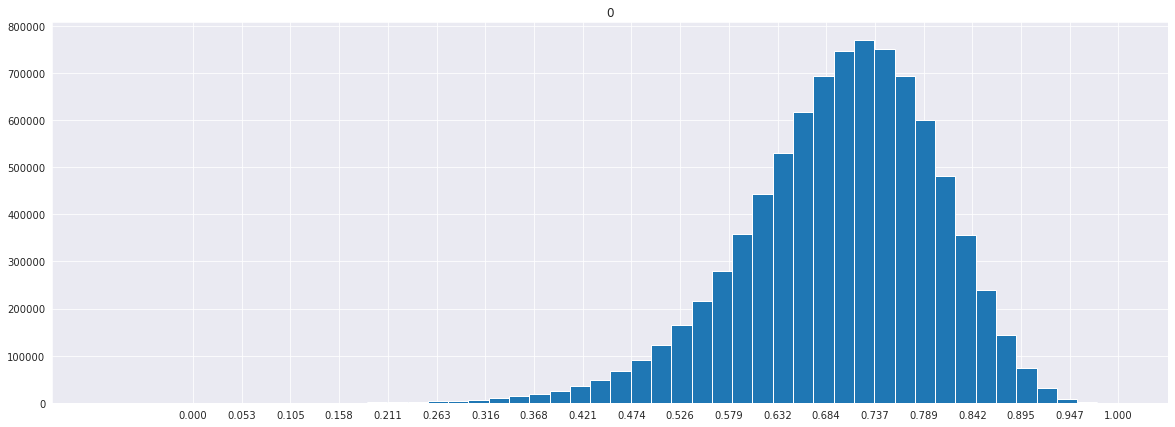

In [176]:
# y-axis indicates = pairs of documents

pd.DataFrame(upper_right).hist(bins=50, figsize=(20,7))
plt.xticks(np.linspace(0,1.0, 20))
plt.show()

### --- EDA for day of week reading activity ---
* Just out of curiosity

In [5]:
sql = """
   SELECT 
       GA_date, GA_cmsNaturalId, SUM(GA_pageViews) AS pvs 
   FROM 
       `api-project-901373404215.DataMart.DataMart6` 
    WHERE
        GA_date BETWEEN "2020-01-01" AND "2020-12-31"
    GROUP BY GA_date, GA_cmsNaturalId 
    ORDER BY pvs DESC
"""

# Send the query to the api and return a df
ga = client.query(sql).to_dataframe()
print("Shape: ", ga.shape) #9.51

Shape:  (68897959, 3)


In [6]:
sql = """
    SELECT 
           GA_date, GA_cmsNaturalId, SUM(GA_pageViews) AS pvs 
       FROM 
           `api-project-901373404215.DataMart.DataMart6` 
        WHERE
            GA_date BETWEEN "2021-01-01" AND "2021-05-22"
        GROUP BY 
            GA_date, GA_cmsNaturalId 
        HAVING 
            pvs > 100
        ORDER BY 
            pvs DESC   
"""

# Send the query to the api and return a df

ga_100 = client.query(sql).to_dataframe()
print("Shape: ", ga_100.shape) 

ga_100 = pd.DataFrame(ga_100.sort_values("GA_date").groupby("GA_date").pvs.sum()).reset_index()
print("Per day Shape: ", ga_100.shape)

Shape:  (615695, 3)
Per day Shape:  (142, 2)


In [7]:
ga.GA_date = pd.to_datetime(ga.GA_date)
ga["dow"] = ga.GA_date.dt.day_name() 
ga["month"] = ga.GA_date.dt.month

ga_100.GA_date = pd.to_datetime(ga_100.GA_date)
ga_100["dow"] = ga_100.GA_date.dt.day_name() 
ga_100["month"] = ga_100.GA_date.dt.month

In [9]:
idx_reshuffle = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

* 2020:
    * unique articles read - Wed, Thurs, Tues, Mon; Fri, Sun, Sat
    * sum pvs - Mon, Tues, Wed, Thurs, Sun, 
    * avg. pvs - 

In [10]:
# 2020 unique articles read
pd.DataFrame(ga.groupby('dow')['GA_cmsNaturalId'].nunique()).reindex(idx_reshuffle)

,GA_cmsNaturalId
dow,
Monday,672958
Tuesday,673308
Wednesday,675467
Thursday,674031
Friday,660203
Saturday,636216
Sunday,647624


In [11]:
# 2020 sum pvs
pd.DataFrame(ga.groupby("dow").pvs.sum()).reindex(idx_reshuffle)

,pvs
dow,
Monday,569049612
Tuesday,536792020
Wednesday,525613790
Thursday,523969143
Friday,493501658
Saturday,455201830
Sunday,523245182


In [13]:
pd.DataFrame(ga_100.groupby("dow").pvs.sum()).reindex(idx_reshuffle)

,pvs
dow,
Monday,99849391
Tuesday,99645519
Wednesday,99239695
Thursday,99788691
Friday,93612766
Saturday,86812561
Sunday,97296982


In [10]:
import matplotlib.pyplot as plt
import matplotlib.dates as dates

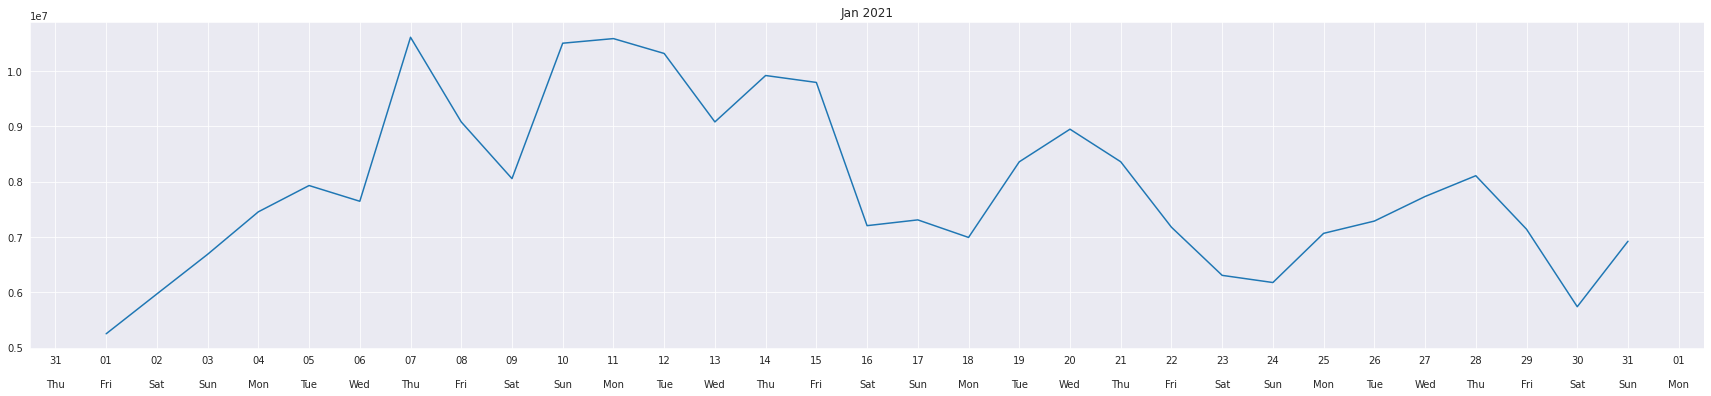

In [11]:
jan = pd.DataFrame(ga[ga.month==1].groupby(["GA_date", "dow"]).pvs.sum())
jan = jan.reset_index()

plt.rcParams["figure.figsize"] = (30,6)
plt.title("Jan 2021")

plt.plot(jan["GA_date"], jan["pvs"])
plt.gca().xaxis.set_major_locator(dates.DayLocator())
plt.gca().xaxis.set_major_formatter(dates.DateFormatter('%d\n\n%a'))

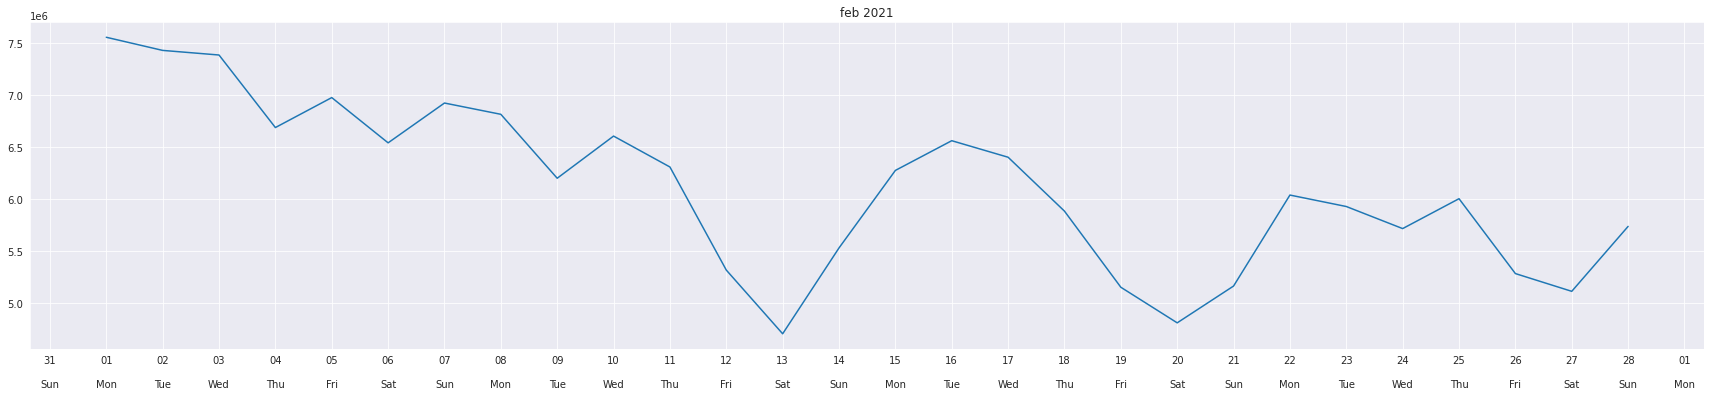

In [69]:
feb = pd.DataFrame(ga[ga.month==2].groupby(["GA_date", "dow"]).pvs.sum())
feb = feb.reset_index()

plt.rcParams["figure.figsize"] = (30,6)
plt.title("feb 2021")

plt.plot(feb["GA_date"], feb["pvs"])
plt.gca().xaxis.set_major_locator(dates.DayLocator())
plt.gca().xaxis.set_major_formatter(dates.DateFormatter('%d\n\n%a'))

<AxesSubplot:xlabel='dow'>

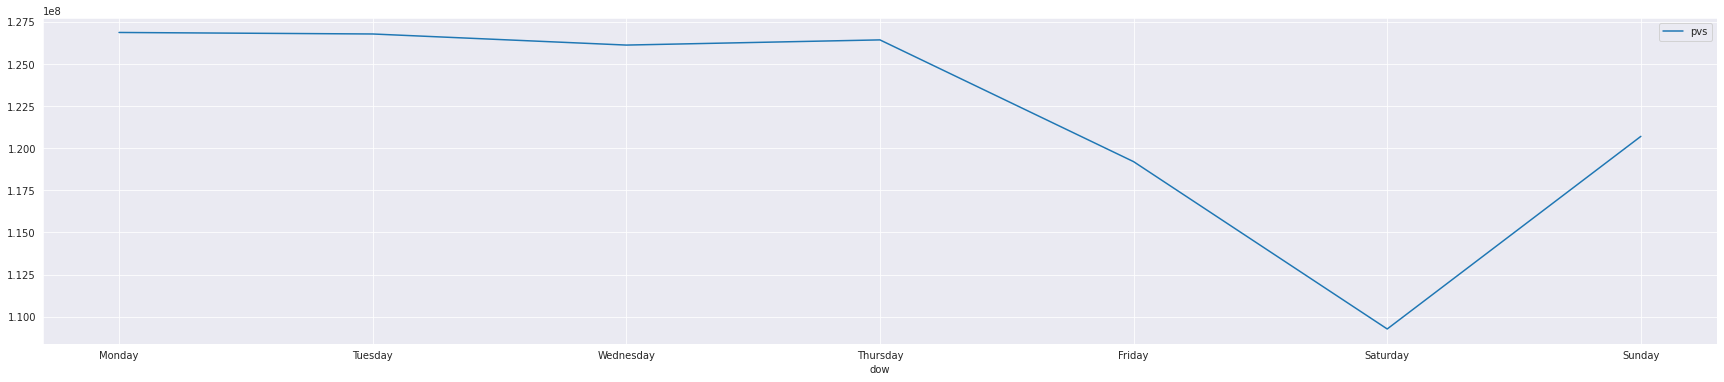

In [12]:
idx_reshuffle = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pd.DataFrame(ga.groupby("dow").pvs.sum()).reindex(idx_reshuffle).plot()

In [14]:
# Grab all the articles for the last 2 days
sql = """
    SELECT distinct LOWER(naturalid) AS naturalid, SAFE.DATETIME(date, "America/New_York") AS publish_timestamp, title, body
    FROM (
        SELECT naturalid, title, body, date, timestamp, RANK() OVER (PARTITION BY LOWER(naturalid) ORDER BY timestamp DESC) AS rank
        FROM `api-project-901373404215.Content.content`
        WHERE visible IS TRUE
            AND type in ('blog','blogslide','newsletter','magazine')
            AND date>=timestamp_sub(current_timestamp(), interval 31 day)
            AND timestamp>=timestamp_sub(current_timestamp(), interval 31 day)
            AND date<=current_timestamp()
    )
    WHERE
    rank=1
"""

# Send the query to the api and return a df
df = client.query(sql).to_dataframe()
print("Shape: ", df.shape)

Shape:  (9119, 4)


In [21]:
df["pub_date"] = df.publish_timestamp.dt.date
df.pub_date = pd.to_datetime(df.pub_date)
df["dow"] = df.pub_date.dt.day_name() 
df["month"] = df.pub_date.dt.month

In [23]:
# 2020 unique articles read
pd.DataFrame(df.groupby('dow')['naturalid'].nunique()).reindex(idx_reshuffle)

,naturalid
dow,
Monday,1757
Tuesday,1874
Wednesday,1468
Thursday,1604
Friday,1381
Saturday,442
Sunday,593
